### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

## Import Section

In [1]:
#!pip install tensorflow-gpu==2.8.3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
tqdm.pandas()
import tensorflow as tf
import math
import timeit
from six.moves import cPickle as pickle
import os
import datetime
import platform
from subprocess import check_output
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow
tensorflow.__version__

'2.9.2'

## Lets pull the CIFAR 10 dataset

In [3]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

170498071/170498071 [==============================] - 2s 0us/step


## Lets Analyse the data

* Shape of each image is 32X32X3 that menas it is a color image

In [4]:
X_train[0].shape


(32, 32, 3)

## Lets See few images

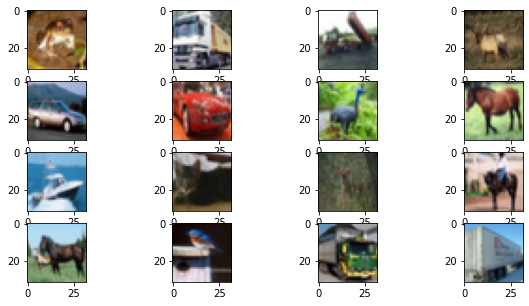

In [5]:
fig = plt.figure(figsize=(10, 5))
rows = 4
columns = 4
for i in range(16):  
  image = X_train[i]
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
plt.show()

## Lets Analyse the classes

In [6]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

* We have 10 Classes which are already label encoded

In [7]:
num_classes = 10

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## Lets convert y_train to one hot encoded vector

In [9]:
# convert to one hot encoing 
#y_train = tf.keras.utils.to_categorical(y_train, num_classes)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes) 
# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

In [10]:
print(y_train.shape)
print(y_test.shape)

(50000,)
(10000,)


## We can see that x_train values are in range of 0-255 as input is image lets normalise the image so that nueral network converge faster


In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

## using similar architechture provided in reference

In [12]:
tf.keras.backend.clear_session()

In [13]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 50
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [14]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=True ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

## Lets train the model

In [15]:
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare training iterator
train_iterator = data_generator.flow(X_train, y_train, batch_size=batch_size)

In [16]:
num_filter = 12
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
# Image Augmentation
#random_flip = layers.RandomFlip("horizontal")(input)
#random_scaling = layers.Rescaling(scale=1./255)(random_flip)
#random_rotation = layers.RandomRotation(0.4)(random_scaling)
#random_zoom = layers.RandomZoom(0.2,0.2)(random_rotation)
#random_contrast = layers.RandomContrast(0.4)(random_zoom)
#random_brightness = layers.RandomBrightness(0.4,value_range=(0,1))(random_contrast)
First_Conv2D = layers.Conv2D(32, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, 32, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 32, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [17]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

In [18]:
print(len(model.layers))

211


In [19]:
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [20]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
%reload_ext tensorboard

In [21]:
# determine Loss function and Optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=5, min_lr=0.000001)

In [26]:
model.fit(train_iterator,batch_size=batch_size,epochs=5,verbose=1,validation_data=(X_test, y_test),callbacks = [checkpoint,reduce_lr,tensorboard_callback])

Epoch 1/5
782/782 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.9068
Epoch 1: val_accuracy did not improve from 0.87340
782/782 [==============================] - 84s 108ms/step - loss: 0.2645 - accuracy: 0.9068 - val_loss: 0.4605 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 2/5
782/782 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9146
Epoch 2: val_accuracy did not improve from 0.87340
782/782 [==============================] - 85s 108ms/step - loss: 0.2440 - accuracy: 0.9146 - val_loss: 0.6535 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/5
782/782 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.9174
Epoch 3: val_accuracy did not improve from 0.87340
782/782 [==============================] - 84s 107ms/step - loss: 0.2338 - accuracy: 0.9174 - val_loss: 0.4759 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 4/5
782/782 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9197
Epoch 4: val_accuracy did 

In [27]:
model.fit(train_iterator,batch_size=batch_size,epochs=15,verbose=1,validation_data=(X_test, y_test),callbacks = [checkpoint,reduce_lr,tensorboard_callback])

Epoch 1/15
782/782 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9255
Epoch 1: val_accuracy did not improve from 0.87340
782/782 [==============================] - 84s 107ms/step - loss: 0.2113 - accuracy: 0.9255 - val_loss: 0.5140 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 2/15
782/782 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9261
Epoch 2: val_accuracy did not improve from 0.87340
782/782 [==============================] - 84s 108ms/step - loss: 0.2101 - accuracy: 0.9261 - val_loss: 0.5460 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 3/15
782/782 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9288
Epoch 3: val_accuracy did not improve from 0.87340
782/782 [==============================] - 85s 109ms/step - loss: 0.2022 - accuracy: 0.9288 - val_loss: 0.4144 - val_accuracy: 0.8724 - lr: 0.0010
Epoch 4/15
782/782 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.9305
Epoch 4: val_accuracy 

In [28]:
model.fit(train_iterator,batch_size=batch_size,epochs=15,verbose=1,validation_data=(X_test, y_test),callbacks = [checkpoint,reduce_lr,tensorboard_callback])

Epoch 1/15
782/782 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9709
Epoch 1: val_accuracy did not improve from 0.89610
782/782 [==============================] - 85s 108ms/step - loss: 0.0844 - accuracy: 0.9709 - val_loss: 0.3761 - val_accuracy: 0.8957 - lr: 1.0000e-04
Epoch 2/15
782/782 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9709
Epoch 2: val_accuracy did not improve from 0.89610
782/782 [==============================] - 83s 106ms/step - loss: 0.0838 - accuracy: 0.9709 - val_loss: 0.3831 - val_accuracy: 0.8939 - lr: 1.0000e-04
Epoch 3/15
782/782 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9721
Epoch 3: val_accuracy did not improve from 0.89610
782/782 [==============================] - 84s 107ms/step - loss: 0.0803 - accuracy: 0.9721 - val_loss: 0.3754 - val_accuracy: 0.8952 - lr: 1.0000e-04
Epoch 4/15
782/782 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9720
Epoch 4: v

In [29]:
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range = 0.2,shear_range=0.1,zoom_range=0.1,horizontal_flip=True)
# prepare training iterator
train_iterator = data_generator.flow(X_train, y_train, batch_size=batch_size)

In [30]:
model.fit(train_iterator,batch_size=batch_size,epochs=10,verbose=1,validation_data=(X_test, y_test),callbacks = [checkpoint,reduce_lr,tensorboard_callback])

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9695
Epoch 1: val_accuracy did not improve from 0.89750
782/782 [==============================] - 85s 109ms/step - loss: 0.0865 - accuracy: 0.9695 - val_loss: 0.4057 - val_accuracy: 0.8952 - lr: 1.0000e-05
Epoch 2/10
782/782 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9704
Epoch 2: val_accuracy did not improve from 0.89750
782/782 [==============================] - 84s 108ms/step - loss: 0.0836 - accuracy: 0.9704 - val_loss: 0.4039 - val_accuracy: 0.8956 - lr: 1.0000e-05
Epoch 3/10
782/782 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9695
Epoch 3: val_accuracy did not improve from 0.89750
782/782 [==============================] - 84s 108ms/step - loss: 0.0841 - accuracy: 0.9695 - val_loss: 0.4051 - val_accuracy: 0.8946 - lr: 1.0000e-05
Epoch 4/10
782/782 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9710
Epoch 4: v

In [32]:
model.fit(train_iterator,batch_size=batch_size,epochs=15,verbose=1,validation_data=(X_test, y_test),callbacks = [checkpoint,reduce_lr,tensorboard_callback])

Epoch 1/15
782/782 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9709
Epoch 1: val_accuracy did not improve from 0.89750
782/782 [==============================] - 85s 109ms/step - loss: 0.0834 - accuracy: 0.9709 - val_loss: 0.4030 - val_accuracy: 0.8953 - lr: 1.0000e-05
Epoch 2/15
782/782 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9713
Epoch 2: val_accuracy did not improve from 0.89750
782/782 [==============================] - 84s 107ms/step - loss: 0.0796 - accuracy: 0.9713 - val_loss: 0.4020 - val_accuracy: 0.8952 - lr: 1.0000e-05
Epoch 3/15
782/782 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9718
Epoch 3: val_accuracy did not improve from 0.89750
782/782 [==============================] - 84s 107ms/step - loss: 0.0795 - accuracy: 0.9718 - val_loss: 0.4025 - val_accuracy: 0.8954 - lr: 1.0000e-05
Epoch 4/15
782/782 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9721
Epoch 4: v

In [ ]:
data_generator = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, rotation_range = 0.6,shear_range=0.1,zoom_range=0.4,horizontal_flip=True)
# prepare training iterator
train_iterator = data_generator.flow(X_train, y_train, batch_size=batch_size)

In [38]:
# determine Loss function and Optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 0.0001),metrics=['accuracy'])

In [41]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=3, min_lr=0.000001)

In [42]:
model.fit(train_iterator,batch_size=batch_size,epochs=15,verbose=1,validation_data=(X_test, y_test),callbacks = [checkpoint,reduce_lr,tensorboard_callback])

Epoch 1/15
782/782 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9688
Epoch 1: val_accuracy did not improve from 0.89750
782/782 [==============================] - 123s 111ms/step - loss: 0.0902 - accuracy: 0.9688 - val_loss: 0.4174 - val_accuracy: 0.8957 - lr: 1.0000e-04
Epoch 2/15
782/782 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9690
Epoch 2: val_accuracy did not improve from 0.89750
782/782 [==============================] - 85s 109ms/step - loss: 0.0879 - accuracy: 0.9690 - val_loss: 0.4029 - val_accuracy: 0.8948 - lr: 1.0000e-04
Epoch 3/15
782/782 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9688
Epoch 3: val_accuracy did not improve from 0.89750
782/782 [==============================] - 85s 108ms/step - loss: 0.0860 - accuracy: 0.9688 - val_loss: 0.4063 - val_accuracy: 0.8942 - lr: 1.0000e-04
Epoch 4/15
782/782 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9701
Epoch 4: 

In [45]:
data_generator = ImageDataGenerator(width_shift_range=0.3, height_shift_range=0.3, rotation_range = 0.6,shear_range=0.3,zoom_range=0.4,horizontal_flip=True)
# prepare training iterator
train_iterator = data_generator.flow(X_train, y_train, batch_size=batch_size)

In [46]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=4, min_lr=0.000000001)

In [48]:
model.fit(train_iterator,batch_size=batch_size,epochs=3,verbose=1,validation_data=(X_test, y_test),callbacks = [checkpoint,reduce_lr,tensorboard_callback])

Epoch 1/3
782/782 [==============================] - ETA: 0s - loss: 0.7970 - accuracy: 0.7960
Epoch 1: val_accuracy did not improve from 0.89750
782/782 [==============================] - 86s 110ms/step - loss: 0.7970 - accuracy: 0.7960 - val_loss: 0.5673 - val_accuracy: 0.8686 - lr: 1.0000e-09
Epoch 2/3
782/782 [==============================] - ETA: 0s - loss: 0.7903 - accuracy: 0.7992
Epoch 2: val_accuracy did not improve from 0.89750
782/782 [==============================] - 89s 114ms/step - loss: 0.7903 - accuracy: 0.7992 - val_loss: 0.5685 - val_accuracy: 0.8687 - lr: 1.0000e-09
Epoch 3/3
782/782 [==============================] - ETA: 0s - loss: 0.7877 - accuracy: 0.7983
Epoch 3: val_accuracy did not improve from 0.89750
782/782 [==============================] - 85s 109ms/step - loss: 0.7877 - accuracy: 0.7983 - val_loss: 0.5676 - val_accuracy: 0.8685 - lr: 1.0000e-09


In [49]:
model.load_weights('/content/model_save/weights-15-0.8975.hdf5')

In [50]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 6s 19ms/step - loss: 0.3961 - accuracy: 0.8975
Test loss: 0.3961257040500641
Test accuracy: 0.8974999785423279


In [51]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk
